In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_207'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/func_0'

In [33]:
file_name = "functional_channel_2_moco_zscore_highpass.h5"
load_path = os.path.join(func_path, file_name)
save_directory = os.path.join(func_path, "corr")
grey_only = False
print(load_path)

/oak/stanford/groups/trc/data/Ilana/2P/data/fly_207/func_0/functional_channel_2_moco_zscore_highpass.h5


In [4]:
with h5py.File(load_path, 'r') as hf:
    brain = hf['data'][:]

In [5]:
x_dim = brain.shape[0]
y_dim = brain.shape[1]
z_dim = brain.shape[2]

In [6]:
corr_brain = np.zeros((x_dim,y_dim,z_dim))

In [7]:
behaviors = ["dRotLabZneg", "dRotLabZpos", "dRotLabY"]

In [41]:
timestamps = timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
np.shape(timestamps)

Trying to load timestamp data from hdf5 file.
Success.


(3384, 49)

In [24]:
fps = 100
fictrac_raw = brainsss.load_fictrac(os.path.join(func_path, 'fictrac'))
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
timestamps = timestamps[:np.shape(brain)[3]]
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000 

Trying to load timestamp data from hdf5 file.
Success.


In [34]:
if grey_only:
    vision_path = os.path.join(func_path, 'visual')
    stim_ids, angles = brainsss.get_stimulus_metadata(vision_path)
    t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
    stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
    grey_starts = []
    grey_stops = []
    for i,stim in enumerate(stim_ids):
        if stim == 'ConstantBackground':
            grey_starts.append(stimulus_start_times[i])
            grey_stops.append(stimulus_start_times[i]+60)
    grey_starts = [i*1000 for i in grey_starts] # convert from s to ms
    grey_stops = [i*1000 for i in grey_stops] # convert from s to ms
    idx_to_use = []
    for i in range(len(grey_starts)):
        idx_to_use.extend(np.where((grey_starts[i] < timestamps[:,0]) & (timestamps[:,0] < grey_stops[i]))[0])
    ### this is now a list of indices where grey stim was presented
else:
    idx_to_use = list(range(timestamps.shape[0]))

In [25]:
for behavior in behaviors:
    for z in range(z_dim):

        ### interpolate fictrac to match the timestamps of this slice
        fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
        for i in range(x_dim):
            for j in range(y_dim):
                # nan to num should be taken care of in zscore, but checking here for some already processed brains
                if np.any(np.isnan(brain[i,j,z,:])):
                    printlog(F'warning found nan at x = {i}; y = {j}; z = {z}')
                    corr_brain[i,j,z] = 0
                elif len(np.unique(brain[i,j,z,:])) == 1:
                #     if np.unique(brain[i,j,z,:]) != 0:
                #         printlog(F'warning found non-zero constant value at x = {i}; y = {j}; z = {z}')
                    corr_brain[i,j,z] = 0
                else:
                    #idx_to_use can be used to select a subset of timepoints
                    corr_brain[i,j,z] = scipy.stats.pearsonr(fictrac_interp[idx_to_use], brain[i,j,z,:][idx_to_use])[0]


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



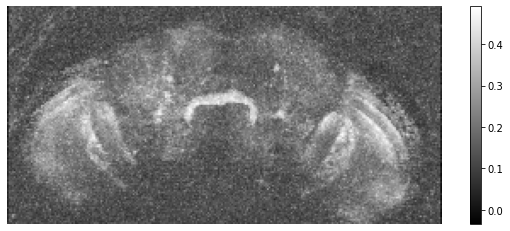

In [36]:
def save_maxproj_img(file):
    brain = np.asarray(nib.load(file).get_data().squeeze(), dtype='float32')

    plt.figure(figsize=(10,4))
    plt.imshow(np.max(brain,axis=-1).T,cmap='gray')
    plt.axis('off')
    plt.colorbar()
    
    save_file = file[:-3] + 'png'
    plt.savefig(save_file, bbox_inches='tight', dpi=300)

if not os.path.exists(save_directory):
        os.mkdir(save_directory)

if 'warp' in load_path:
    warp_str = '_warp'
else:
    warp_str = ''
if grey_only:
    grey_str = '_grey'
else:
    grey_str = ''
if 'zscore' not in load_path:
    no_zscore_highpass_str = '_mocoonly'
else:
    no_zscore_highpass_str = ''

date = time.strftime("%Y%m%d")
#     date = '20220420'

save_file = os.path.join(save_directory, '{}_corr_{}{}{}{}.nii'.format(date, behavior, warp_str, grey_str, no_zscore_highpass_str))
nib.Nifti1Image(corr_brain, np.eye(4)).to_filename(save_file)
save_maxproj_img(save_file)




In [46]:
np.shape(brain)

(256, 128, 49, 300)